# Project Title: Weather Condition Prediction Using Hidden Markov Models (HMM)

## Project Description
This project aims to predict weather conditions based on various meteorological features using Hidden Markov Models (HMM). 

The dataset consists of hourly weather data, including temperature, humidity, wind speed, visibility, and atmospheric pressure. The project involves data generation, preprocessing, model training, prediction, and evaluation of the model's performance.

<h1>Importing Required Libraries for the Project<h1>

In [ ]:
# Importing Required Libraries for the Project

import numpy as np  # Numerical computations and array/matrix operations
import pandas as pd  # DataFrame for structured data management
import matplotlib.pyplot as plt  # Plotting basic charts
import seaborn as sns  # Advanced statistical plotting with aesthetic visualizations
from sklearn.model_selection import train_test_split  # Split dataset into train/test sets
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Feature scaling and label encoding
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    f1_score, mean_squared_error, mean_absolute_error, recall_score
)  # Model evaluation metrics
from hmmlearn import hmm  # Hidden Markov Models
from scipy import stats  # Statistical computations
from sklearn.ensemble import RandomForestClassifier  # Random Forest for feature importance


### Data Preprocessing:

(1) Handle missing values.


(2) Normalize the features.


(3) Encode categorical variables.

In [ ]:
# Load dataset and handle missing values
df = pd.read_csv('C:/Users/Hossein/Desktop/New folder (7)/HW_4_ML_1403_dataset/Weather Data_3.csv') # Load CSV file
df.dropna(inplace=True)  # Remove rows with missing values

# Convert Date/Time column to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Extract basic time features
df['Month'] = df['Date/Time'].dt.month  # Month
df['Hour'] = df['Date/Time'].dt.hour  # Hour
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek  # Day of the week (Monday=0, Sunday=6)
df['Temp_Humidity_Interaction'] = df['Temp_C'] * df['Rel Hum_%']  # Interaction of temperature and humidity
df['Wind_Visibility_Interaction'] = df['Wind Speed_km/h'] * df['Visibility_km']  # Interaction of wind speed and visibility

# Season feature
def get_season(month):
    if month in [12, 1, 2]:  # Winter
        return 'Winter'
    elif month in [3, 4, 5]:  # Spring
        return 'Spring'
    elif month in [6, 7, 8]:  # Summer
        return 'Summer'
    else:  # Autumn
        return 'Autumn'
df['Season'] = df['Month'].apply(get_season)  # Apply function to extract season

# Time of day feature
def get_time_of_day(hour): 
    if 6 <= hour < 12:  # Morning
        return 'Morning'
    elif 12 <= hour < 18:  # Afternoon
        return 'Afternoon'
    elif 18 <= hour < 24:  # Evening
        return 'Evening'
    else:  # Midnight
        return 'Midnight'
df['TimeOfDay'] = df['Hour'].apply(get_time_of_day)  # Apply function to extract time of day

# Weekend feature
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # 1 if weekend, else 0

# Temperature change compared to previous hour
df['Temp_Shift'] = df['Temp_C'].diff().fillna(0)  # Compute temperature change relative to previous hour

# Pressure change compared to previous hour
df['Press_Shift'] = df['Press_kPa'].diff().fillna(0)  # Compute pressure change

# Humidity change compared to previous hour
df['Humidity_Shift'] = df['Rel Hum_%'].diff().fillna(0)  # Compute humidity change

# Wind intensity (define strong wind as a binary feature)
df['Wind_Intensity'] = df['Wind Speed_km/h'].apply(lambda x: 1 if x > 30 else 0)  # 1 if wind > 30 km/h, else 0

# Encode categorical features (Season and TimeOfDay)
label_encoder = LabelEncoder()
df['Season_Encoded'] = label_encoder.fit_transform(df['Season'])  # Encode season
df['TimeOfDay_Encoded'] = label_encoder.fit_transform(df['TimeOfDay'])  # Encode time of day

# Drop original columns no longer needed
df.drop(['Date/Time', 'Month', 'Hour', 'DayOfWeek', 'Season', 'TimeOfDay'], axis=1, inplace=True)

# Map complex weather descriptions to simpler values
weather_mapping = {
    'Fog': 'Fog',
    'Freezing Drizzle,Fog': 'Fog',
    'Mostly Cloudy': 'Cloudy',
    'Cloudy': 'Cloudy',
    'Rain': 'Rain',
    'Rain Showers': 'Rain',
    'Mainly Clear': 'Clear',
    'Snow Showers': 'Snow',
    'Snow': 'Snow',
    'Clear': 'Clear',
    'Freezing Rain,Fog': 'Fog',
    'Freezing Rain': 'Rain',
    'Freezing Drizzle': 'Drizzle',
    'Rain,Snow': 'Snow',
    'Moderate Snow': 'Snow',
    'Freezing Drizzle,Snow': 'Snow',
    'Freezing Rain,Snow Grains': 'Snow',
    'Snow,Blowing Snow': 'Snow',
    'Freezing Fog': 'Fog',
    'Haze': 'Haze',
    'Rain,Fog': 'Rain',
    'Drizzle,Fog': 'Drizzle',
    'Drizzle': 'Drizzle',
    'Freezing Drizzle,Haze': 'Drizzle',
    'Freezing Rain,Haze': 'Rain',
    'Snow,Haze': 'Snow',
    'Snow,Fog': 'Snow',
    'Snow,Ice Pellets': 'Snow',
    'Rain,Haze': 'Rain',
    'Thunderstorms,Rain': 'Thunderstorm',
    'Thunderstorms,Rain Showers': 'Thunderstorm',
    'Thunderstorms,Heavy Rain Showers': 'Thunderstorm',
    'Thunderstorms,Rain Showers,Fog': 'Thunderstorm',
    'Thunderstorms': 'Thunderstorm',
    'Thunderstorms,Rain,Fog': 'Thunderstorm',
    'Thunderstorms,Moderate Rain Showers,Fog': 'Thunderstorm',
    'Rain Showers,Fog': 'Rain',
    'Rain Showers,Snow Showers': 'Snow',
    'Snow Pellets': 'Snow',
    'Rain,Snow,Fog': 'Snow',
    'Moderate Rain,Fog': 'Rain',
    'Freezing Rain,Ice Pellets,Fog': 'Snow',
    'Drizzle,Ice Pellets,Fog': 'Snow',
    'Drizzle,Snow': 'Snow',
    'Rain,Ice Pellets': 'Rain',
    'Drizzle,Snow,Fog': 'Snow',
    'Rain,Snow Grains': 'Snow',
    'Rain,Snow,Ice Pellets': 'Snow',
    'Snow Showers,Fog': 'Snow',
    'Moderate Snow,Blowing Snow': 'Snow'
}

# Apply mapping to Weather column
df['Weather'] = df['Weather'].map(weather_mapping)

# Encode weather as numeric values
label_encoder = LabelEncoder()
df['Weather_Encoded'] = label_encoder.fit_transform(df['Weather'])

# Normalize features
scaler = StandardScaler()
features = df[['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa']]
features_scaled = scaler.fit_transform(features)  # Standardize features

# Encode categorical variables again (Weather)
label_encoder = LabelEncoder()
df['Weather_Encoded'] = label_encoder.fit_transform(df['Weather'])  # Encode weather

# Random Forest model to compute feature importance
rf_model = RandomForestClassifier(random_state=42)
# Train the model on training data
rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_model.feature_importances_


In [20]:
df.head(10)

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather,Temp_Humidity_Interaction,Wind_Visibility_Interaction,IsWeekend,Temp_Shift,Press_Shift,Humidity_Shift,Wind_Intensity,Season_Encoded,TimeOfDay_Encoded,Weather_Encoded
0,-1.8,-3.9,86,4,8.0,101.24,Fog,-154.8,32.0,1,0.0,0.00,0.0,0,3,2,3
1,-1.8,-3.7,87,4,8.0,101.24,Fog,-156.6,32.0,1,0.0,0.00,1.0,0,3,2,3
2,-1.8,-3.4,89,7,4.0,101.26,Fog,-160.2,28.0,1,0.0,0.02,2.0,0,3,2,3
3,-1.5,-3.2,88,6,4.0,101.27,Fog,-132.0,24.0,1,0.3,0.01,-1.0,0,3,2,3
4,-1.5,-3.3,88,7,4.8,101.23,Fog,-132.0,33.6,1,0.0,-0.04,0.0,0,3,2,3
5,-1.4,-3.3,87,9,6.4,101.27,Fog,-121.8,57.6,1,0.1,0.04,-1.0,0,3,2,3
6,-1.5,-3.1,89,7,6.4,101.29,Fog,-133.5,44.8,1,-0.1,0.02,2.0,0,3,3,3
7,-1.4,-3.6,85,7,8.0,101.26,Fog,-119.0,56.0,1,0.1,-0.03,-4.0,0,3,3,3
8,-1.4,-3.6,85,9,8.0,101.23,Fog,-119.0,72.0,1,0.0,-0.03,0.0,0,3,3,3
9,-1.3,-3.1,88,15,4.0,101.20,Fog,-114.4,60.0,1,0.1,-0.03,3.0,0,3,3,3


In [21]:
df['Weather'].unique()

array(['Fog', 'Cloudy', 'Rain', 'Clear', 'Snow', 'Drizzle', 'Haze',
       'Thunderstorm'], dtype=object)

### Model Implementation:

(1) Implement a Hidden Markov Model.


(2)Train the model on a portion of the dataset and validate its performance on a separate test set.

In [22]:
X = features_scaled
y = df['Weather_Encoded']

In [ ]:
# Define a Hidden Markov Model with 8 hidden states
# Using diagonal covariance and 1000 iterations
# Stop the algorithm if changes in likelihood are less than 0.05
model = hmm.GaussianHMM(
    n_components=8,          # Number of hidden states
    n_iter=1000,             # Maximum number of iterations
    covariance_type="diag",  # Diagonal covariance for each state
    random_state=42,         # Random seed for reproducibility
    init_params="kmeans",    # Initialize means using KMeans
    tol=0.05                 # Convergence threshold for stopping
)


In [ ]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Hidden Markov Model on the training data
model.fit(X_train)

GaussianHMM(init_params='kmeans', n_components=8, n_iter=1000, random_state=42,
            tol=0.05)

### Prediction:

Use the trained model to predict hidden states (weather conditions) based on the input features.

In [ ]:
# The output of this line is an array indicating 
# which hidden state each sample in the test data is assigned to
hidden_states = model.predict(X_test)

### Evaluation:

Evaluate the model's performance using:


(1) confusion matrices


(2) Accuracy and precision


(3) F1 score


(4) ROC Curve


(5) AUC


(6) Precision-Recall Curve


(7) classification reports


(8) Log loss


(9) Recall


(10) Mean Absolute Error(MAE)


(11) Mean Squared Error(MSE)


(12) Root Mean Squared Error(RMSE)


(13) R2 score


(14) Mean Absolute Percentage Error(MAPE)

In [ ]:
# Evaluate model performance using various metrics

# Compute accuracy: the proportion of correct predictions over total predictions
acc = accuracy_score(y_test, hidden_states)

# Compute weighted F1 score
f1 = f1_score(y_test, hidden_states, average='weighted')

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, hidden_states)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, hidden_states)

# Compute Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mean_squared_error(y_test, hidden_states))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, hidden_states)

# Optional: compute weighted recall
# recall = recall_score(y_test, hidden_states, average='weighted')

# Extract unique labels from true and predicted data
labels = np.unique(np.concatenate([y_test, hidden_states]))

# Generate final classification report
report = classification_report(
    y_test, 
    hidden_states, 
    labels=labels, 
    target_names=label_encoder.inverse_transform(labels), 
    zero_division=1
)


### Visualization:

(1) Visualize the actual vs. predicted weather conditions over time.


(2) Display feature importance to understand which meteorological factors influence the predictions.

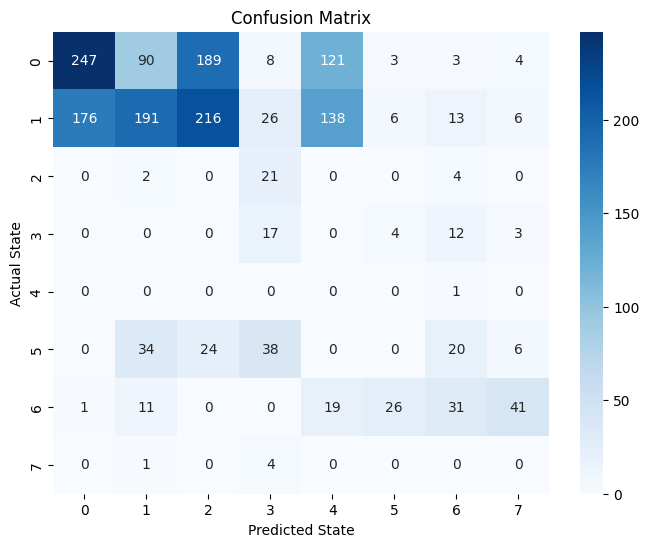

C:\Users\Hossein\AppData\Local\Temp\ipykernel_2620\2470915560.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metrics, palette='viridis')


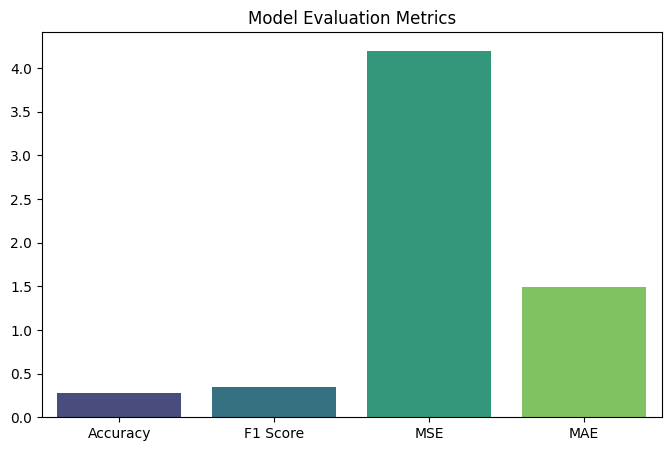

Accuracy: 0.27660785429709733
F1 Score: 0.35015504586117374
Mean Squared Error: 4.200910643141719
Mean Absolute Error: 1.491747296528173
Confusion Matrix:
 [[247  90 189   8 121   3   3   4]
 [176 191 216  26 138   6  13   6]
 [  0   2   0  21   0   0   4   0]
 [  0   0   0  17   0   4  12   3]
 [  0   0   0   0   0   0   1   0]
 [  0  34  24  38   0   0  20   6]
 [  1  11   0   0  19  26  31  41]
 [  0   1   0   4   0   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

       Clear       0.58      0.37      0.45       665
      Cloudy       0.58      0.25      0.35       772
     Drizzle       0.00      0.00      0.00        27
         Fog       0.15      0.47      0.23        36
        Haze       0.00      0.00      0.00         1
        Rain       0.00      0.00      0.00       122
        Snow       0.37      0.24      0.29       129
Thunderstorm       0.00      0.00      0.00         5

    accuracy                           0.28      17

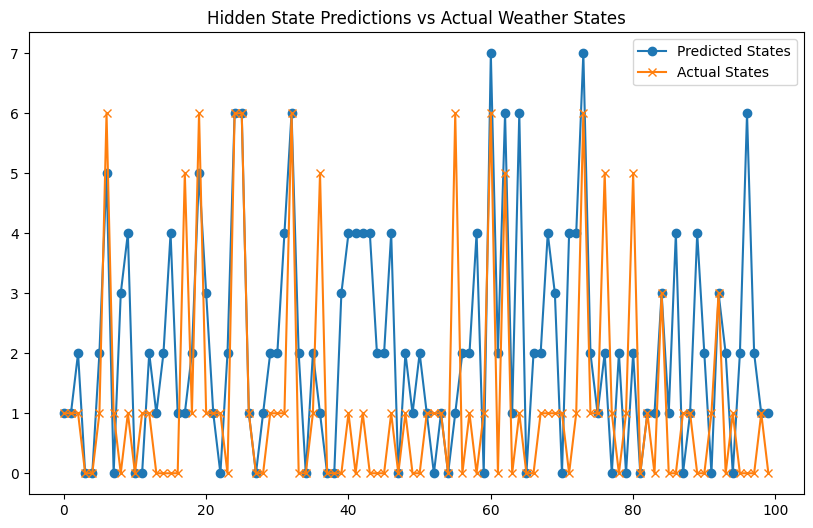

C:\Users\Hossein\AppData\Local\Temp\ipykernel_2620\2470915560.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Weather_Encoded', data=df, palette='viridis')


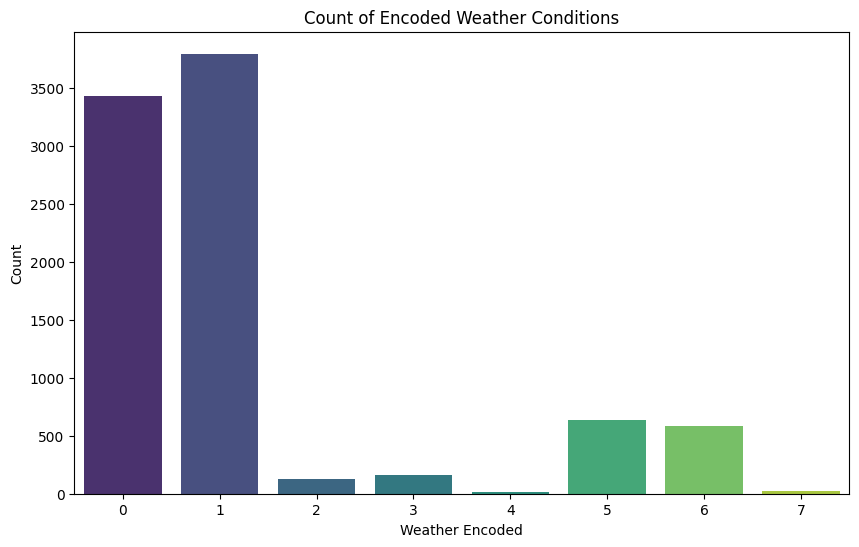

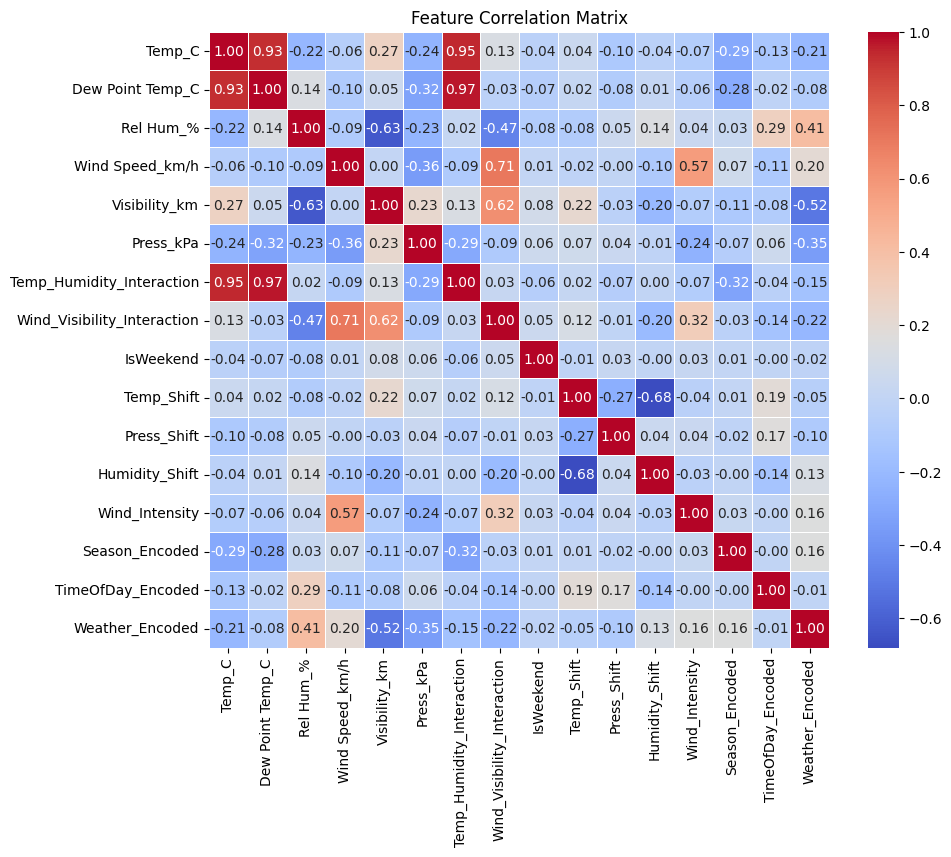

<Figure size 1200x800 with 0 Axes>

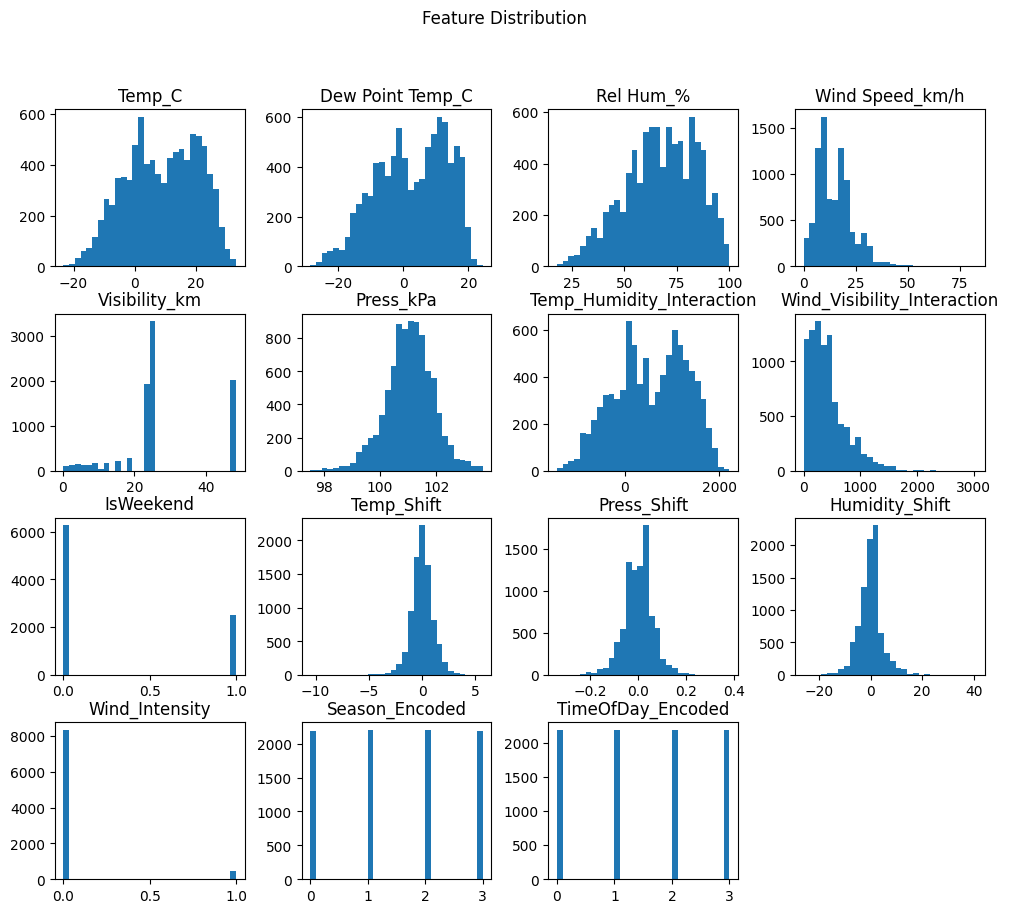

C:\Users\Hossein\AppData\Local\Temp\ipykernel_2620\2470915560.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette='viridis')


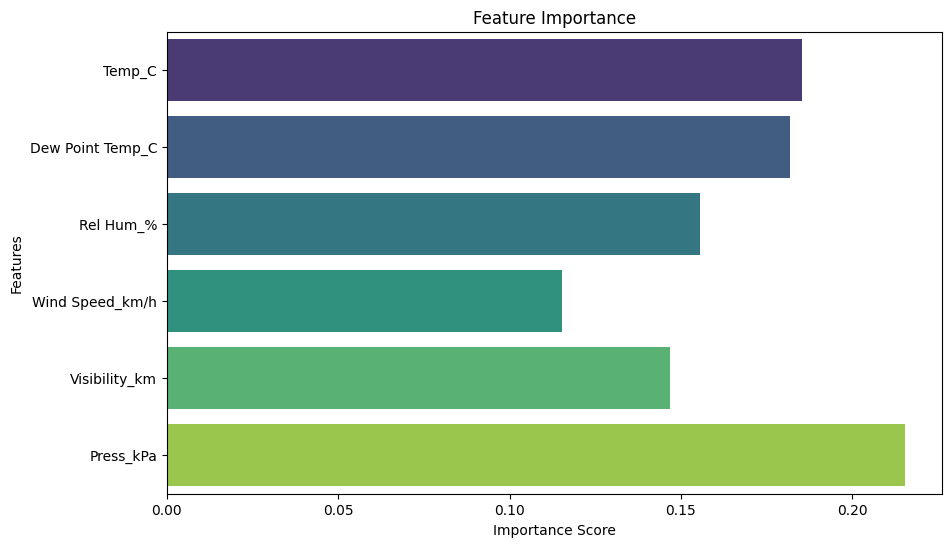

In [ ]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual State')
plt.xlabel('Predicted State')
plt.show()

# Model evaluation metrics
metrics = [acc, f1, mse, mae]
metric_names = ['Accuracy', 'F1 Score', 'MSE', 'MAE']
plt.figure(figsize=(8, 5))
sns.barplot(x=metric_names, y=metrics, palette='viridis')
plt.title('Model Evaluation Metrics')
plt.show()

# Print evaluation metrics
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
# print("Recall:", recall)
# print("Root Mean Squared Error (RMSE):", rmse)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

# Visualize predicted hidden states vs actual weather states
plt.figure(figsize=(10, 6))
plt.plot(hidden_states[:100], label='Predicted States', marker='o')
plt.plot(y_test[:100].values, label='Actual States', marker='x')
plt.title('Hidden State Predictions vs Actual Weather States')
plt.legend()
plt.show()

# Distribution of each weather class
plt.figure(figsize=(10, 6))
sns.countplot(x='Weather_Encoded', data=df, palette='viridis')
plt.title('Count of Encoded Weather Conditions')
plt.xlabel('Weather Encoded')
plt.ylabel('Count')
plt.show()

# Select numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=[np.number])  # Select numeric columns from the dataframe

# Plot feature correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Select numeric columns again (redundant but kept)
numeric_df = df.select_dtypes(include=[np.number])

# Feature distributions
plt.figure(figsize=(12, 8))
numeric_df.drop('Weather_Encoded', axis=1).hist(bins=30, figsize=(12, 10), grid=False)
plt.suptitle('Feature Distribution')
plt.show()

# Plot feature importance
feature_names = ['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa']
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()